In [1]:
import os
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer

In [132]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

###### List of files in the project directory for future reference

In [8]:
os.listdir()

['.DS_Store',
 '.git',
 '.github',
 '.ipynb_checkpoints',
 'Books_ratings_R_version',
 'books_rating_project_EDA_3.ipynb',
 'books_rating_project_EDA_Cleaning_1.ipynb',
 'books_rating_project_EDA_Cleaning_2.ipynb',
 'data',
 'Project_Description_ML_2023.docx.pdf',
 'Python_labs_project.ipynb',
 'README.md',
 'requirements.txt']

###### Data is kept seprate from the main project folder. Listing the data files that are available

In [9]:
os.listdir('data')

['books.csv',
 'cleaned_books.csv',
 'uncleaned_books.csv',
 'uncleaned_books.csv_bad_lines.txt',
 'working_books.csv']

###### For this part of the project, we will be working with the cleaned_books.csv (cleaned in earlier notebooks Cleaning 1 and 2. Future suggestions for cleaning will be updated in EDA_cleaning files so that the final working copy will always be cleaned_books.csv

In [10]:
folder = 'data/'
f_ratings = 'cleaned_books.csv'
ratings_path = folder + f_ratings

In [11]:
###### Note to self: potentially use this as a further cleaning file and end with a cleaner 
###### file of actual feature to be used in the model

In [12]:
df_ratings = pd.read_csv(ratings_path)
df_ratings.head()

,bookID,title,authors,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,4.78


###### Looking at the columns and looking ahead, we can safely guess we can drop the bookID column from consideration as a feature. We might be able to do something interesting with the title, if we were to do some extra nlp processing on the title, but that is beyond the scope of this iteration of the project. We might be able to make use of the author(s). There is currently some debate as to what affect the author of the book will have on the rating. isbn and isbn13 at first glance do not provide any information and will not be used in the current inquiry (as a side note, if we were to take the time to parse the isbn numbers, they actually provide interesting infromation such as the publisher, langauge published in, issuing agengy of the publication code, etc. but, much like the NLP work needed to parse the title, the parsing of isbn codes is beyond the scope of the current project. We might be able to do some work with language, ratings_count and text_reviews count and will be keeping those for the time being. publication date code be an interesting feature, but we would need more information (such as snapshots in time from publication date, whether a book is a reprint of a classic, if a new introduction from another author boosted popularity and therefore perception and sentiment, etc) so we will not be working with publication date during this project. Publisher could have something to do with average rating (again thinking along the lines of how marketing affects percepton of a book, or the cover of a book, etc)


In [13]:
###### Giving a list of the columns as they appear, both as a nice visual, and because sometimes, showing the list will actually
###### show hidden spaces in column names that might cause problems later *** note to self-clean up column names in future
###### iterations of EDA data cleaning
list(df_ratings.columns)

['bookID',
 'title',
 'authors',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'average_rating']

In [14]:
####### Creating a variable to store our working columns. Tried the difference trick used below, but it changed the 
####### ordering of the columns
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'average_rating']

In [15]:
df_ratings_keep = df_ratings[keep_cols]
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78


In [16]:
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)

In [17]:
def round_to_increment_5(number):
    '''Return the string version of the target rounded in .5% increments'''
    rounded_number = round(number / 0.5) * 0.5
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)
        
#### ***Note to self: consider changing these functions to return as floats, and then use astype to change to strings to more
####    easily switch between log reg problem to classification problem

In [18]:
def str_buckets(num: float) -> str:
    '''Group ratings roughly by the standard deviation coupled with human
       reasoning'''
    if num < 3.0:
        return 'not my favorite'
    if num >= 3.0 and num < 3.6:
        return 'fine'
    if num >= 3.6 and num < 4.3:
        return 'good'
    if num >= 4.3 and num < 4.6:
        return 'very good'
    if num >= 4.6:
        return 'excelent'


In [19]:
df_ratings_keep['target_10'] = df_ratings_keep['average_rating'].round(decimals=1)

C:\Users\joesa\AppData\Local\Temp\ipykernel_23188\3663998029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_10'] = df_ratings_keep['average_rating'].round(decimals=1)


In [20]:
df_ratings_keep['target_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)

C:\Users\joesa\AppData\Local\Temp\ipykernel_23188\1083081448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)


In [21]:
df_ratings_keep['target_50'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)

C:\Users\joesa\AppData\Local\Temp\ipykernel_23188\2689911333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_50'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)


In [22]:
df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=0)

C:\Users\joesa\AppData\Local\Temp\ipykernel_23188\2542177934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=0)


In [23]:
df_ratings_keep['target_str'] = df_ratings_keep['average_rating'].apply(str_buckets)

In [24]:
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating,target_10,target_25,target_50,target_1,target_str
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57,4.6,4.5,4.5,5.0,very good
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49,4.5,4.5,4.5,4.0,very good
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42,4.4,4.5,4.5,4.0,very good
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56,4.6,4.5,4.5,5.0,very good
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78,4.8,4.75,5.0,5.0,excelent


# Testing with .10 buckets

In [25]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_10']

In [26]:
df_ratings_10 = df_ratings_keep[keep_cols_num]

In [27]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [29]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [30]:
logreg.fit(x_train, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [31]:
predictions = logreg.predict(x_test)

In [32]:
score = logreg.score(x_test, y_test)

In [33]:
score

0.16202455825097334

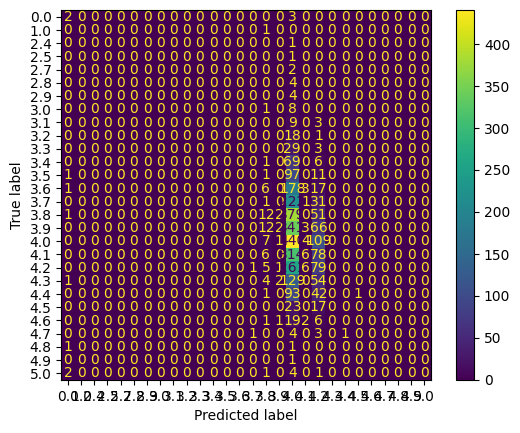

In [34]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [35]:
clf = RandomForestClassifier(n_estimators=100)

In [36]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [37]:
scores

array([0.13029525, 0.15404365, 0.13928113, 0.13551702, 0.12331407])

In [38]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [39]:
predictions = clf.predict(x_test)

In [40]:
clf.score(x_test, y_test)

0.13836477987421383

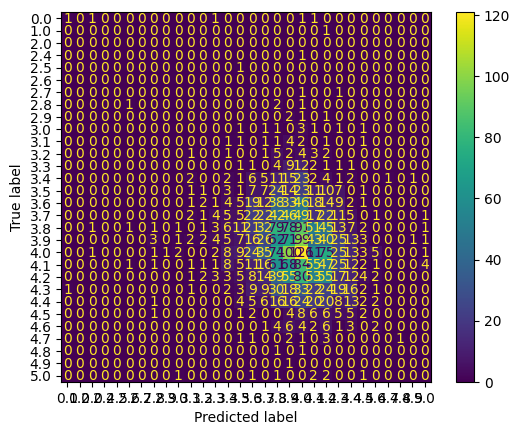

In [41]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [42]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_10']

In [43]:
df_ratings_10 = df_ratings_keep[keep_cols]

In [44]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Isolate categorical features for encoding using the hash trick

In [46]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [47]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

### Create the vectorizers

In [48]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

### Vectorize the categorical vars and change them to arrays

In [49]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [50]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [51]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [71]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [67]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [68]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [73]:
logreg.fit(train_feats, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [75]:
predictions = logreg.predict(test_feats)

In [76]:
score = logreg.score(test_feats, y_test)
score

0.1530398322851153

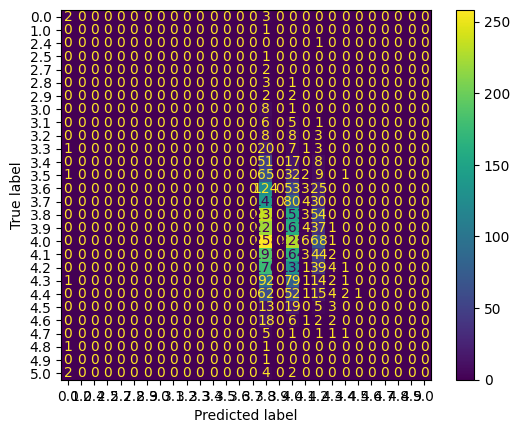

In [77]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [78]:
clf = RandomForestClassifier(n_estimators=100)

In [79]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [80]:
scores

array([0.20346598, 0.20410783, 0.21630295, 0.19781631, 0.22222222])

In [82]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [83]:
predictions = clf.predict(test_feats)

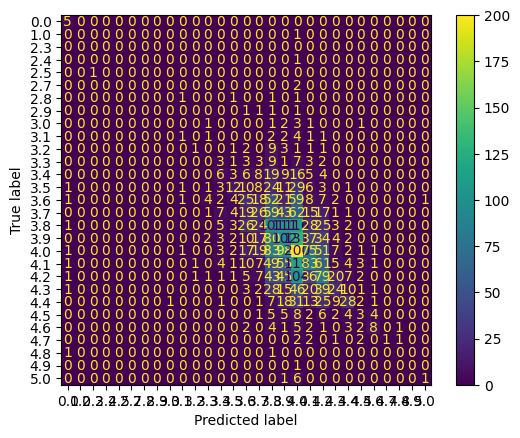

In [84]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [85]:
clf.score(test_feats, y_test)

0.21144055106319257

# Testing with .25 buckets

In [86]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_25']

In [87]:
df_ratings_25 = df_ratings_keep[keep_cols_num]

In [89]:
df_ratings_25.head()

,num_pages,ratings_count,text_reviews_count,target_25
0,652,2095690,27591,4.5
1,870,2153167,29221,4.5
2,352,6333,244,4.5
3,435,2339585,36325,4.5
4,2690,41428,164,4.75


In [91]:
y = df_ratings_25['target_25']
x = df_ratings_25[df_ratings_25.columns.difference(['target_25'])]

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [93]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [94]:
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [95]:
predictions = logreg.predict(x_test)

In [96]:
score = logreg.score(x_test, y_test)

In [97]:
score

0.3641808924827793

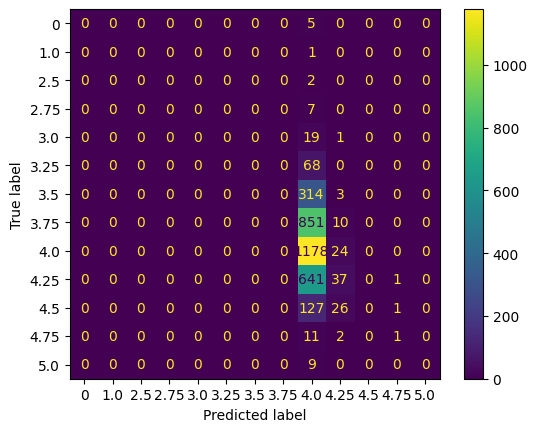

In [98]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)



In [99]:
clf = RandomForestClassifier(n_estimators=100)

In [100]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [101]:
scores

array([0.31322208, 0.33119384, 0.31322208, 0.31085421, 0.32048812])

In [102]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [103]:
predictions = clf.predict(x_test)

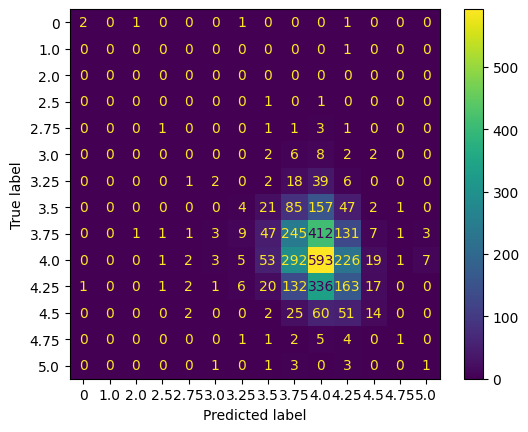

In [104]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [105]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_25']

In [106]:
df_ratings_25 = df_ratings_keep[keep_cols]

In [107]:
y = df_ratings_25['target_25'].astype(str)
x = df_ratings_25[df_ratings_25.columns.difference(['target_25'])]

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [109]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [110]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [111]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [112]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [113]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [114]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [115]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [116]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [117]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [119]:
logreg.fit(train_feats, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [120]:
predictions = logreg.predict(test_feats)

In [121]:
score = logreg.score(test_feats, y_test)
score

0.36058700209643607

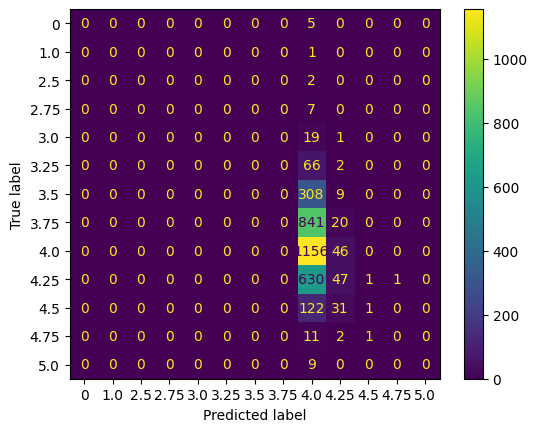

In [122]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [123]:
clf = RandomForestClassifier(n_estimators=100)

In [124]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.41655969, 0.42105263, 0.41976893, 0.42196532, 0.40783558])

In [125]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [126]:
predictions = clf.predict(test_feats)

In [127]:
clf.score(test_feats, y_test)

0.431266846361186

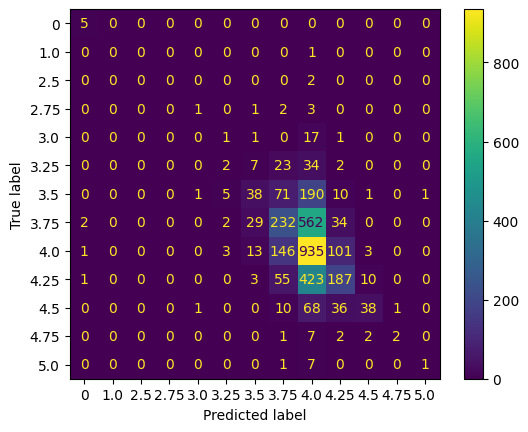

In [128]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [129]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
for i in range(len(precision)):
    print(i, precision[i], recall[i], f1[i], support[i])

0 0.5555555555555556 1.0 0.7142857142857143 5
1 0.0 0.0 0.0 1
2 0.0 0.0 0.0 2
3 0.0 0.0 0.0 7
4 0.0 0.0 0.0 20
5 0.15384615384615385 0.029411764705882353 0.04938271604938271 68
6 0.41304347826086957 0.11987381703470032 0.1858190709046455 317
7 0.4288354898336414 0.2694541231126597 0.3309557774607704 861
8 0.4157403290351267 0.7778702163061564 0.541871921182266 1202
9 0.5013404825737265 0.27540500736377027 0.3555133079847909 679
10 0.7037037037037037 0.24675324675324675 0.3653846153846154 154
11 0.6666666666666666 0.14285714285714285 0.23529411764705882 14
12 0.5 0.1111111111111111 0.1818181818181818 9


In [136]:
f1 = f1_score(y_test, predictions, average='micro')
f1

0.43126684636118606

# Testing with .5 buckets

In [140]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_50']

In [141]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_50']

In [142]:
df_ratings_50 = df_ratings_keep[keep_cols_num]

In [143]:
y = df_ratings_50['target_50']
x = df_ratings_50[df_ratings_50.columns.difference(['target_50'])]

In [144]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [145]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [146]:
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [147]:
predictions = logreg.predict(x_test)

In [148]:
score = logreg.score(x_test, y_test)

In [149]:
score

0.6549865229110512

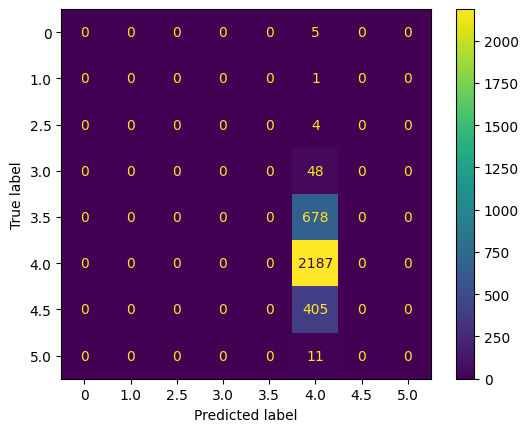

In [150]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [151]:
clf = RandomForestClassifier(n_estimators=100)

In [152]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [153]:
scores

array([0.63157895, 0.61874198, 0.62580231, 0.62556198, 0.60950546])

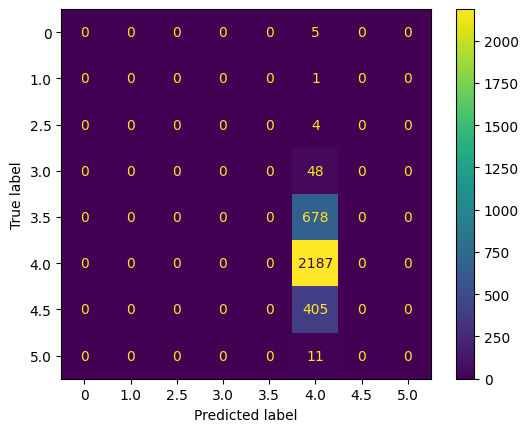

In [154]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [155]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [157]:
predictions = clf.predict(x_test)

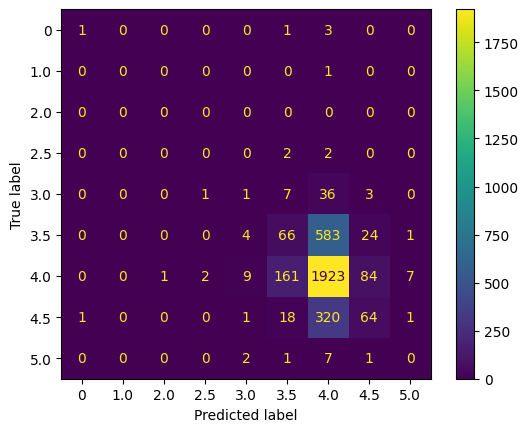

In [158]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [159]:
clf.score(x_test, y_test)

0.6154537286612758

In [161]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.5539344739489739

In [166]:
df_ratings_50 = df_ratings_keep[keep_cols]

In [167]:
y = df_ratings_50['target_50'].astype(str)
x = df_ratings_50[df_ratings_50.columns.difference(['target_50'])]

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [169]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [170]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [171]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [172]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [173]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [174]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [175]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [176]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [177]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [178]:
logreg.fit(train_feats, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [179]:
predictions = logreg.predict(test_feats)

In [180]:
score = logreg.score(test_feats, y_test)
score

0.6549865229110512

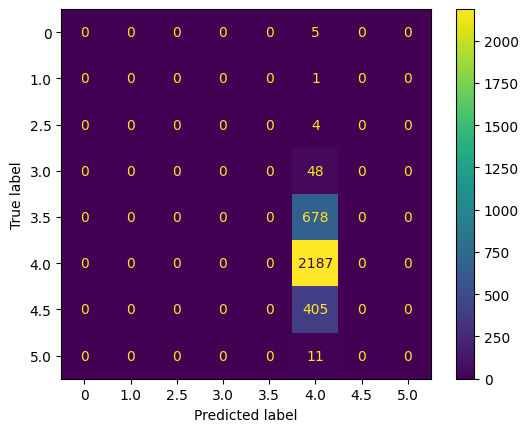

In [181]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [182]:
clf = RandomForestClassifier(n_estimators=100)

In [183]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.6944801 , 0.68741977, 0.69191271, 0.68657675, 0.68529223])

In [184]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [185]:
predictions = clf.predict(test_feats)

In [186]:
clf.score(test_feats, y_test)

0.6825396825396826

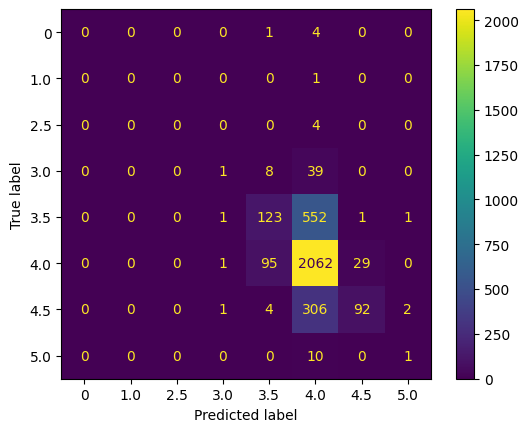

In [187]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [188]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.6212682624454836

# Testing with whole numbers

In [191]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_1']

In [192]:
df_ratings_1 = df_ratings_keep[keep_cols_num]

In [193]:
y = df_ratings_1['target_1']
x = df_ratings_1[df_ratings_whole.columns.difference(['target_1'])]

In [194]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [195]:
clf = RandomForestClassifier(n_estimators=100)

In [196]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [197]:
scores

array([0.90757381, 0.90115533, 0.9114249 , 0.91072575, 0.90558767])

In [198]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [199]:
predictions = clf.predict(x_test)

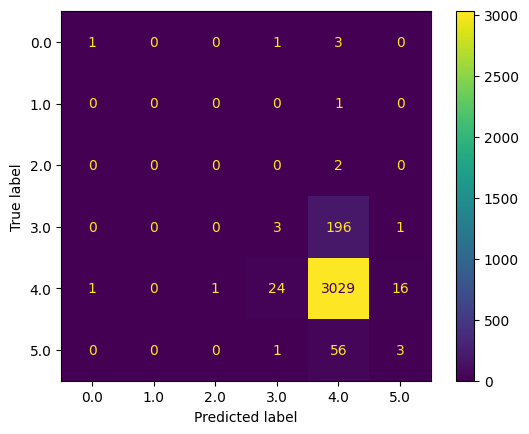

In [200]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [201]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_1']

In [202]:
df_ratings_1 = df_ratings_keep[keep_cols]

In [207]:
y = df_ratings_1['target_1']
x = df_ratings_1[df_ratings_1.columns.difference(['target_1'])]

In [208]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [209]:
clf = RandomForestClassifier(n_estimators=100)

In [210]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [211]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [212]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [213]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [214]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [215]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [216]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [217]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [219]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [220]:
scores

array([0.91720154, 0.91720154, 0.9139923 , 0.91779062, 0.91907514])

In [222]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [223]:
predictions = clf.predict(test_feats)

In [224]:
clf.score(test_feats, y_test)

0.9200359389038635

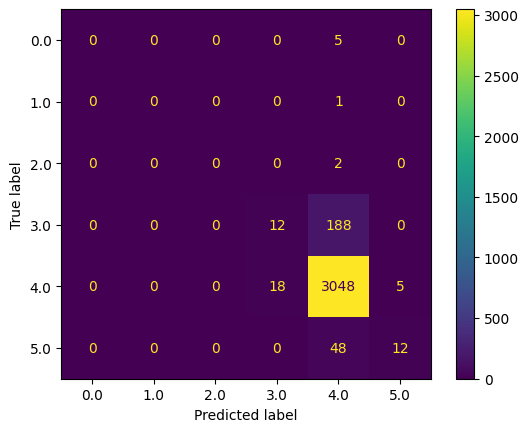

In [225]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [226]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.8929941874445043

# Testing with string buckets
## "not my favorite": < 3.0
## "fine": 3.0 - 3.6
## "good": 3.6 - 4.3
## "very good": 4.3 - 4.6
## "excelent": > 4.6

In [227]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_str']

In [242]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_str']

In [230]:
df_ratings_str = df_ratings_keep[keep_cols_num]

In [231]:
y = df_ratings_str['target_str']
x = df_ratings_str[df_ratings_str.columns.difference(['target_str'])]

In [232]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [233]:
clf = RandomForestClassifier(n_estimators=100)

In [234]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

array([0.78241335, 0.77471117, 0.77406932, 0.7822736 , 0.76621708])

In [235]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [236]:
predictions = clf.predict(x_test)

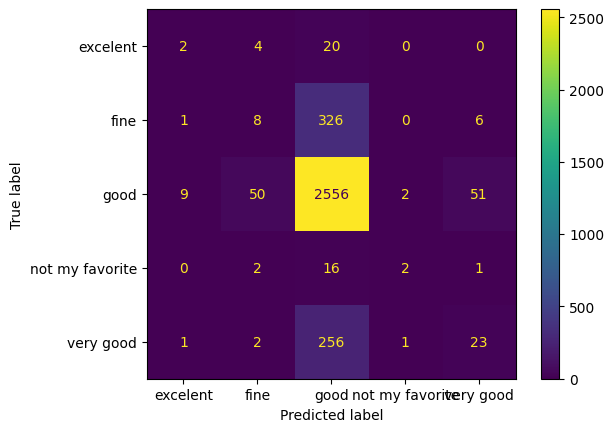

In [237]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [238]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.7156875563926096

In [243]:
df_ratings_str = df_ratings_keep[keep_cols]

In [246]:
y = df_ratings_str['target_str']
x = df_ratings_str[df_ratings_str.columns.difference(['target_str'])]

In [247]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [248]:
clf = RandomForestClassifier(n_estimators=100)

In [249]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [250]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [251]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [252]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [253]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [254]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [255]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [256]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [257]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

array([0.80872914, 0.81386393, 0.81322208, 0.80796403, 0.80924855])

In [258]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [259]:
predictions = clf.predict(test_feats)

In [260]:
clf.score(test_feats, y_test)

0.8161126085654388

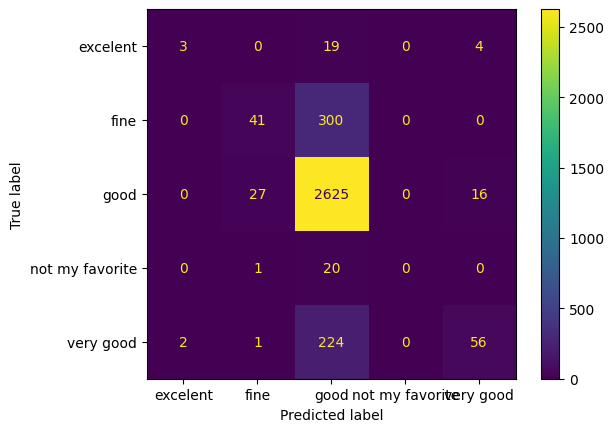

In [261]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [262]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.7646785722141628

In [ ]:
new_df = df_ratings_keep.drop(df_ratings_keep[
    df_ratings_keep["ratings_count"] == 0].index, inplace=False)